# EEG Data Statistics

`01_Data_Curation1`과 `02_Data_Curation2`에서 저장한 EEG 데이터의 분포를 전반적으로 살펴보는 노트북.

-----

## 환경 구성

In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%cd ..

D:\GitHub\eeg_analysis


In [3]:
# Load some packages
import os
import glob
import json
import datetime
import string

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.patches import FancyBboxPatch
import scienceplots
import statistics

import pprint
from tqdm.auto import tqdm

import numpy as np
import torch

# custom package
from datasets.caueeg_dataset import CauEegDataset
from datasets.caueeg_data_curation import MultiEegLabel

In [3]:
# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('default') 
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 
#  'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 
#  'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 
#  'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
#  'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

plt.rcParams['image.interpolation'] = 'bicubic'
plt.rcParams["font.family"] = 'Helvetica' # 'NanumGothic' # for Hangul in Windows

In [4]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.')

2.1.2+cu118
cuda is available.


-----

## Curated Data 불러오기

In [5]:
# Data file path
curate_folder = r'local/dataset/caueeg-dataset'
output_folder = r'local/output/imgs'

os.makedirs(output_folder, exist_ok=True)

In [8]:
with open(os.path.join(curate_folder, 'annotation_debug.json'), 'r') as json_file:
# with open(os.path.join(curate_folder, 'annotation.json'), 'r') as json_file:
    annotation = json.load(json_file)

pprint.pprint({k: (v if k != 'data' else v[:5]) for (k, v) in annotation.items()}, width=250)

{'data': [{'age': 78, 'birth': '1940-06-02', 'dx1': 'mci_rf', 'edfname': '00001809_261018', 'record': '2018-10-26T15:46:26', 'serial': '00001', 'symptom': ['mci', 'mci_amnestic', 'mci_amnestic_rf']},
          {'age': 56, 'birth': '1960-12-04', 'dx1': 'smi', 'edfname': '00029426_020817', 'record': '2017-08-02T16:14:56', 'serial': '00002', 'symptom': ['normal', 'smi']},
          {'age': 93, 'birth': '1924-10-19', 'dx1': 'vascular mci', 'edfname': '00047327_090718', 'record': '2018-07-09T15:29:10', 'serial': '00003', 'symptom': ['mci', 'mci_vascular']},
          {'age': 78, 'birth': '1941-03-16', 'dx1': 'load', 'edfname': '00048377_070819', 'record': '2019-08-07T13:55:25', 'serial': '00004', 'symptom': ['dementia', 'ad', 'load']},
          {'age': 75, 'birth': '1941-03-16', 'dx1': 'mci (ef) multi-domain', 'edfname': '00048377_070916', 'record': '2016-09-07T10:36:01', 'serial': '00005', 'symptom': ['mci', 'mci_amnestic', 'mci_amnestic_ef', 'mci_multi_domain']}],
 'dataset_name': 'CAUEE

In [9]:
with open(os.path.join(curate_folder, 'annotation_debug.json'), 'r') as json_file:
# with open(os.path.join(curate_folder, 'annotation.json'), 'r') as json_file:
    annotation = json.load(json_file)

with open(os.path.join(curate_folder, 'dementia.json'), 'r') as json_file:
    dementia = json.load(json_file)

subject_set = []
counter = 0
for split in ['train_split', 'validation_split', 'test_split']:
    for task_data in dementia[split]:
        for data in annotation['data']:
            if data['serial'] == task_data['serial']:
                subject_set.append(data['edfname'].split('_')[0])
                break
print(len(subject_set))
print(len(set(subject_set)))

1187
976


-----

## 샘플 신호열 시각화

In [10]:
print(len(annotation["data"]))
print()

pprint.pprint(annotation["data"][0])
print()

fname = os.path.join(curate_folder, 'signal/memmap', annotation["data"][0]['serial'] + '.dat')
signal = np.memmap(fname, dtype='int32', mode='r').reshape(21, -1)
print(signal.shape)

1379

{'age': 78,
 'birth': '1940-06-02',
 'dx1': 'mci_rf',
 'edfname': '00001809_261018',
 'record': '2018-10-26T15:46:26',
 'serial': '00001',
 'symptom': ['mci', 'mci_amnestic', 'mci_amnestic_rf']}

(21, 145000)


In [11]:
np.array(signal)[:19].sum(axis=0)

array([ -4, -10, -10, ...,  -4,   0,  -4])

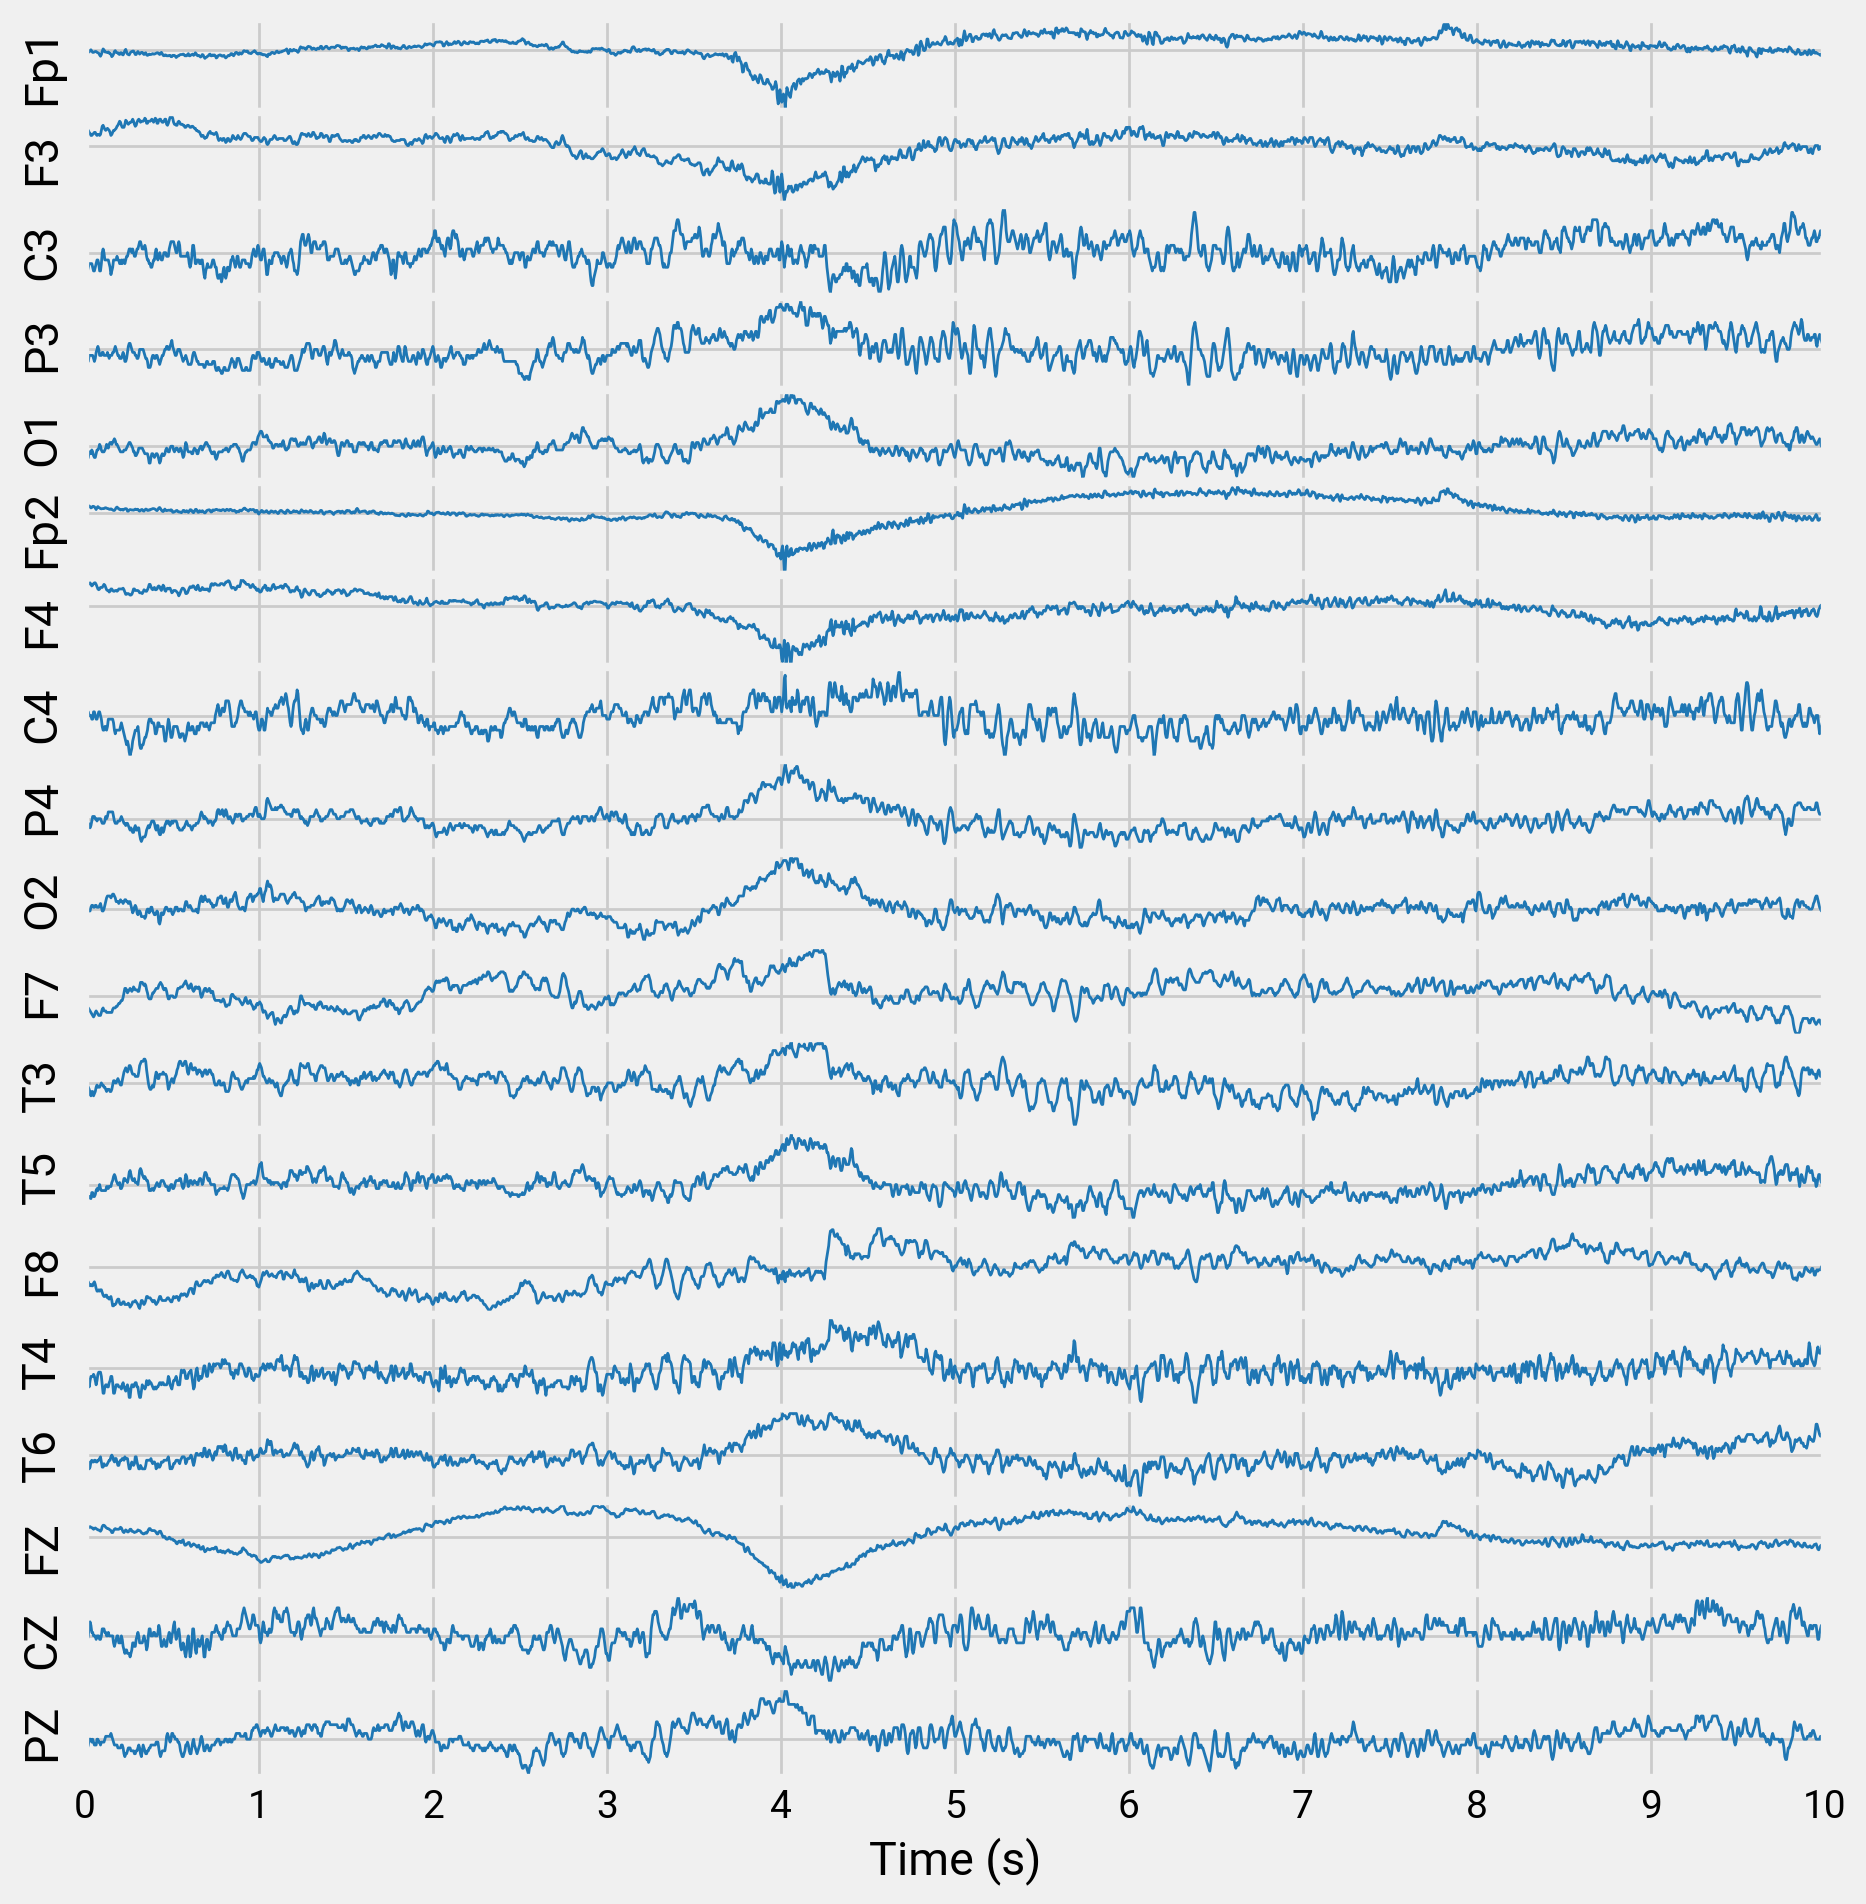

[[  -3   -4   -2 ...   -7   -4   -4]
 [  13   13   14 ...   -4   -3   -2]
 [  -2   -3   -4 ...    5    5    4]
 ...
 [  -1   -2   -3 ...    1    1   -2]
 [ -39  -51  -69 ...    9   17    7]
 [ -58 -850 -682 ...    2    3   -1]]


In [12]:
plt.style.use('classic') 
plt.style.use('default') 
plt.style.use('fivethirtyeight') # default, ggplot, fivethirtyeight, bmh, dark_background, classic
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'Roboto'})
plt.rcParams["savefig.dpi"] = 1200

duration = 2000
start = 115000 - 1000
end = start + duration

fig = plt.figure(num=1, clear=True, figsize=(10.0, 12.0))
fig.subplots_adjust(hspace=0)

for i, channel in enumerate(annotation['signal_header']):
    if channel in ['Photic', 'EKG']:
        continue
    ax = fig.add_subplot(len(annotation['signal_header']), 1, i + 1)
    ax.plot(signal[i, start:end], lw=1, c='tab:blue')
    ax.set_xlim(0, end - start)

    ax.set_ylabel(channel.split('-')[0])
    
    ax.set_xticks(np.arange(round(duration / 200) + 1) * 200)
    ax.set_xticklabels([])
    # ax.tick_params(axis='x', width=0.1, length=0.1)
    ax.set_yticks([0])
    ax.set_yticklabels([])

ax.set_xticks(np.arange(round(duration / 200) + 1) * 200)
ax.set_xticklabels(np.arange(round(duration / 200) + 1))


# ax.set_title('Diagnoses in DB')
ax.set_xlabel('Time (s)')
# ax.set_ylabel('The number of recordings')

fig.savefig(os.path.join(output_folder, 'signal_example.pdf'), transparent=True)
plt.show()
fig.clear()
plt.close(fig)

print(signal[:, start:end])

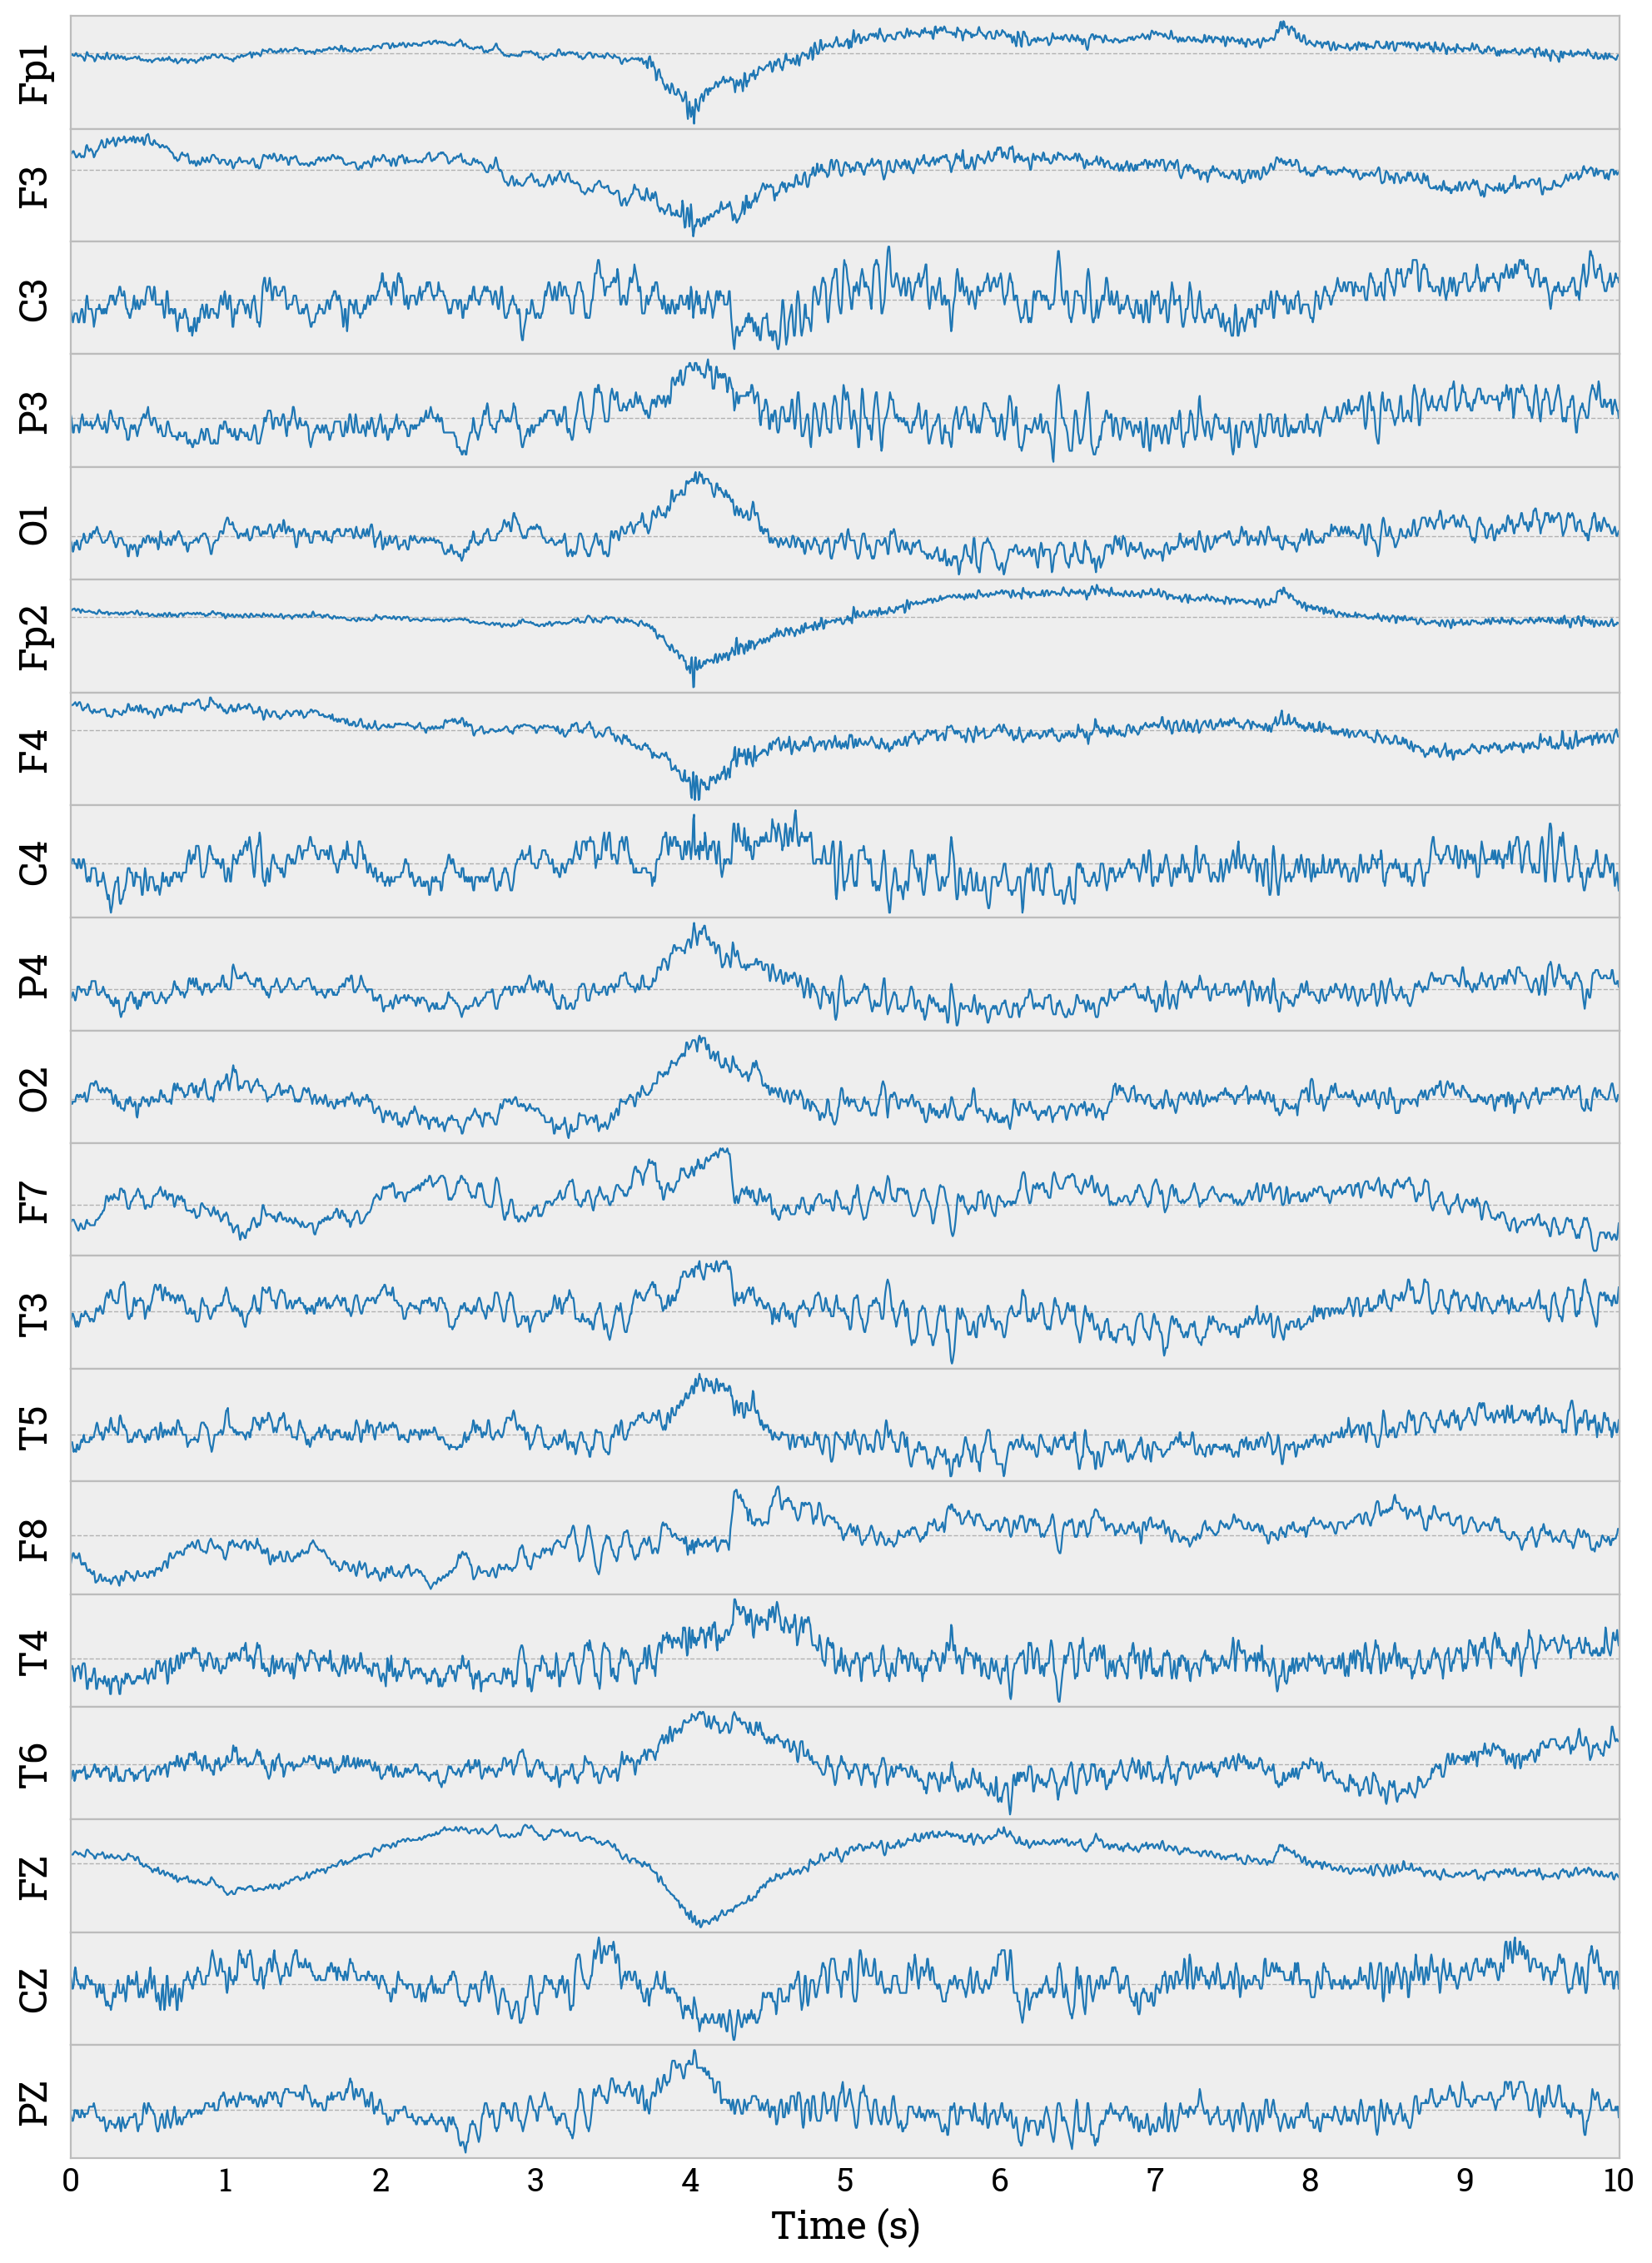

[[  -3   -4   -2 ...   -7   -4   -4]
 [  13   13   14 ...   -4   -3   -2]
 [  -2   -3   -4 ...    5    5    4]
 ...
 [  -1   -2   -3 ...    1    1   -2]
 [ -39  -51  -69 ...    9   17    7]
 [ -58 -850 -682 ...    2    3   -1]]


In [13]:
plt.style.use('classic') 
plt.style.use('default') 
plt.style.use('bmh') # default, ggplot, fivethirtyeight, bmh, dark_background, classic
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'Roboto Slab'})
plt.rcParams["savefig.dpi"] = 1200

duration = 2000
start = 115000 - 1000
end = start + duration

fig, axs = plt.subplots(19, 1, sharex=True, figsize=(10.0, 14.0))
fig.tight_layout(rect=[0, 0.03, 1, 1])
fig.subplots_adjust(hspace=0)

for i, channel in enumerate(annotation['signal_header']):
    if channel in ['Photic', 'EKG']:
        continue
    axs[i].plot(signal[i, start:end], lw=0.8, c='tab:blue')
    axs[i].set_xlim(0, end - start)

    axs[i].set_ylabel(channel.split('-')[0])
    
    axs[i].tick_params(axis='x', width=0.0, length=0.0)
    axs[i].tick_params(axis='y', width=0.0, length=0.0)
    axs[i].set_xticks(np.arange(round(duration / 200) + 1) * 200)
    axs[i].set_xticklabels(np.arange(round(duration / 200) + 1))
    axs[i].xaxis.grid(visible=False)
    axs[i].set_yticks([0])
    axs[i].set_yticklabels([])

axs[-1].set_xticks(np.arange(round(duration / 200) + 1) * 200)
axs[-1].set_xticklabels(np.arange(round(duration / 200) + 1))

# ax.set_title('Diagnoses in DB')
axs[-1].set_xlabel('Time (s)')
# ax.set_ylabel('The number of recordings')

fig.savefig(os.path.join(output_folder, 'signal_example.pdf'), transparent=True)
fig.savefig(os.path.join(output_folder, 'signal_example.svg'), transparent=True)
plt.show()
fig.clear()
plt.close(fig)

print(signal[:, start:end])

-----

## 총 환자수

In [ ]:
a = set()
for m in annotation["data"]:
    a.add(m['edfname'].split('_')[0])

print(len(a))

-----

## 기간

In [ ]:
a = []
for m in annotation["data"]:
    a.append(m['record'])

print(len(a))
pprint.pprint(sorted(a)[0])
pprint.pprint(sorted(a)[-1])

-----

## 데이터 통계

- Signal dynamic range
- Signal mean and variance
- Signal length
- Age
- Diagnosis

In [ ]:
hist_min = []
hist_max = []
hist_mean = []
hist_var = []

hist_length = []
hist_age = []
dict_diagnosis = {}

for (k, m) in enumerate(tqdm(annotation["data"])):
    fname = os.path.join(curate_folder, 'signal/memmap', m['serial'] + '.dat')
    signal = np.memmap(fname, dtype='int32', mode='r').reshape(21, -1)
    
    hist_min.append(np.amin(signal, axis=1))
    hist_max.append(np.amax(signal, axis=1))
    hist_mean.append(np.mean(signal, axis=1))
    hist_var.append(np.var(signal, axis=1))
    
    hist_length.append(signal.shape[1])
    hist_age.append(m['age'])
    
    # d = MultiLabel(**{k: True for k in m['symptom']})
    for l in m['symptom']:
        dict_diagnosis[l] = dict_diagnosis.get(l, 0) + 1
    
hist_min = np.array(hist_min).T
hist_max = np.array(hist_max).T
hist_mean = np.array(hist_mean).T
hist_var = np.array(hist_var).T

hist_length = np.array(hist_length)
hist_age = np.array(hist_age)

print('Done.')

#### Signal min, max, mean, and var

In [ ]:
plt.style.use('default') 

ind = np.argsort(np.sum(hist_max - hist_min, axis=0))

for i in tqdm(range(len(annotation["signal_header"]))):
    fig = plt.figure(num=1, clear=True, 
                 figsize=(60.0, 40.0), constrained_layout=True)

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(hist_min[i, ind], 'b--', linewidth=1.2, label='min')
    ax.plot(hist_max[i, ind], 'c--', linewidth=1.2, label='max')
    ax.plot(hist_mean[i, ind], 'r-', linewidth=1.2, label='mean')
    ax.fill_between(np.arange(hist_mean[i].shape[0]),
                    hist_mean[i, ind] - hist_var[i, ind] / 20, 
                    hist_mean[i, ind] + hist_var[i, ind] / 20, 
                    color='m', alpha=0.4, label='var')

    ax.set_title(annotation["signal_header"][i], fontsize=70)
    plt.legend(loc='upper center', shadow=True, fontsize=70).get_frame().set_facecolor('white')

    fig.savefig(os.path.join(output_folder, f'signal_statistics_c{i + 1:02}.png'))

    fig.clear()
    plt.close(fig)
    
print('Done.')

#### Signal length

In [ ]:
plt.style.use('classic')
plt.style.use('bmh') # default, ggplot, fivethirtyeight, classic
plt.rcParams.update({'font.size': 28})
plt.rcParams.update({'font.family': 'Roboto Slab'})
plt.rcParams["savefig.dpi"] = 1200

fig = plt.figure(num=1, clear=True, 
                 figsize=(18.0, 7.0), constrained_layout=True)

ax = fig.add_subplot(1, 1, 1)
# ax.hist(hist_length / (60 * 200), histtype='stepfilled', color='k', bins=50)
ax.hist(hist_length / (60 * 200), bins=60, color='tab:blue')
ax.vlines(np.mean(hist_length) / (60 * 200), 0, 1, transform=ax.get_xaxis_transform(), colors='r')
# ax.set_title('Signal Length Distribution')
ax.set_xlabel('Signal length (min)')
ax.set_ylabel('Number of recordings')

fig.savefig(os.path.join(output_folder, 'signal_length_distribution.pdf'), transparent=True)

plt.show()
fig.clear()
plt.close(fig)

print(min(hist_length) / 200 / 60)
print(max(hist_length) / 200 / 60)
print(np.mean(hist_length) / 200 / 60)
print(np.std(hist_length) / 200 / 60)

#### Age

In [ ]:
plt.style.use('classic')
plt.style.use('bmh') # default, ggplot, fivethirtyeight, classic
plt.rcParams.update({'font.size': 28})
plt.rcParams.update({'font.family': 'Roboto Slab'})
plt.rcParams["savefig.dpi"] = 1200

fig = plt.figure(num=1, clear=True, 
                 figsize=(18.0, 7.0), constrained_layout=True)

ax = fig.add_subplot(1, 1, 1)
ax.hist(hist_age, bins=60, color='tab:blue')
ax.vlines(np.mean(hist_age), 0, 1, transform=ax.get_xaxis_transform(), colors='r')
# ax.set_title('Age distribution')
ax.set_xlabel('Age')
ax.set_ylabel('Number of recordings')

fig.savefig(os.path.join(output_folder, 'age_distribution.pdf'), transparent=True)

plt.show()
fig.clear()
plt.close(fig)

print(min(hist_age))
print(max(hist_age))
print(np.mean(hist_age))
print(np.std(hist_age))

#### Diagnosis

In [ ]:
plt.style.use('default') 
plt.style.use('fivethirtyeight') # default, ggplot, fivethirtyeight, classic
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams["savefig.dpi"] = 1200

from cycler import cycler
cc = cycler(color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
                   'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])

fig = plt.figure(num=1, clear=True,
                 figsize=(32.0, 14.0), constrained_layout=True)

ax = fig.add_subplot(1, 1, 1)

non_zero_labels = []
for d in dict_diagnosis.keys():
    if dict_diagnosis.get(d, 0) > 0:
        non_zero_labels.append(d)

for d, c in zip(non_zero_labels, cc()):
    # rect = ax.bar(d, dict_diagnosis.get(d, 0), **c, alpha=0.8)
    rect = ax.bar(d, dict_diagnosis.get(d, 0))
    ax.bar_label(rect, padding=3)
    
# rect = ax.bar(*zip(*dict_diagnosis.items()))
# ax.bar_label(rect, padding=3)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right")
# ax.set_title('Diagnoses in DB')
ax.set_xlabel('Diagnosis')
ax.set_ylabel('The number of recordings')

fig.savefig(os.path.join(output_folder, 'diagnosis_distribution.pdf'), transparent=True)

plt.show()
fig.clear()
plt.close(fig)

In [ ]:
plt.style.use('default') 
plt.style.use('fivethirtyeight') # default, ggplot, fivethirtyeight, bmh, dark_background, classic
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams["savefig.dpi"] = 1200

from cycler import cycler
cc = cycler(color=['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple',
                   'tab:brown', 'tab:olive', 'tab:gray', 'tab:olive', 'tab:cyan'])

reorder = [['dementia', 'ad', 'load', 'eoad', 'vd', 'sivd', 'ad-vd-mixed'], 
           ['mci', 'mci-ad',  'mci-amnestic', 'mci-amnestic-ef', 'mci-amnestic-rf', 'mci-non-amnestic', 'mci-multi-domain', 'mci-vascular'], 
           [ 'normal', 'cb-normal', 'smi', 'hc-normal'],
           ['ftd', 'bvftd', 'semantic-aphasia', 'non-fluent-aphasia'], 
           ['parkinson-synd', 'parkinson-disease', 'parkinson-dementia'], ['nph'], ['tga'],]

fig = plt.figure(num=1, clear=True,
                 figsize=(35.0, 15.0), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)

non_zero_labels = []
for dd in reorder:
    nzl = []
    for d in dd:
        d = d.replace('-', '_')
        if dict_diagnosis.get(d, 0) > 0:
            nzl.append(d)
    non_zero_labels.append(nzl)

cnt = 0
margin = 0.46
for c, nzl in zip(cc(), non_zero_labels):
    bb = mtransforms.Bbox([[cnt - margin, 0], [cnt + len(nzl) + margin - 1, 500.0]])
    fancy = FancyBboxPatch(bb.p0, bb.width, bb.height, boxstyle="square,pad=0")
    fancy.set(edgecolor="k", facecolor=c['color'], zorder=1, alpha=0.2)
    ax.add_patch(fancy)
    
    if nzl[0] in ['dementia', 'mci', 'normal']:
        ax.text(cnt + len(nzl) - 0.7, 465, nzl[0], 
                size="large", color=c['color'], 
                style='italic', family='serif',
                horizontalalignment="right", verticalalignment="center")
        ax.text(cnt + len(nzl) - 0.7, 465, nzl[0], 
                size="large", color='k', 
                style='italic', family='serif', 
                horizontalalignment="right", verticalalignment="center", alpha=0.4)
    
    for k, d in enumerate(nzl):
        rect = ax.bar(d.replace('_', '-'), dict_diagnosis.get(d, 0), 
                      width=0.68, color=c['color'])
        ax.bar_label(rect, padding=3)
    
    cnt += len(nzl)

plt.setp(ax.get_xticklabels(), rotation=60, ha="right")
ax.set_xlabel('Diagnosis')
ax.set_ylabel('The number of recordings')

fig.savefig(os.path.join(output_folder, 'diagnosis_distribution.pdf'), transparent=True)

plt.show()
fig.clear()
plt.close(fig)

In [ ]:
plt.style.use('default') 
plt.style.use('fivethirtyeight')  # default, ggplot, fivethirtyeight, bmh, dark_background, classic
plt.rcParams.update({'font.size': 32})
plt.rcParams.update({'font.family': 'Roboto Slab'})  # Arial, Roboto
plt.rcParams["savefig.dpi"] = 1200

reverse_list_of_lists = lambda lst: [reverse_list_of_lists(sublist) if isinstance(sublist, list) else sublist for sublist in reversed(lst)]

from cycler import cycler
cc = cycler(color=reverse_list_of_lists([
    'tab:green', 'tab:orange', 'tab:red', 'tab:blue', 'tab:purple',
    'tab:brown', 'tab:olive']))

reorder = reverse_list_of_lists([
    ['normal', 'cb-normal', 'smi', 'hc-normal'],
    ['mci', 'mci-ad',  'mci-amnestic', 'mci-amnestic-ef', 'mci-amnestic-rf', 'mci-non-amnestic', 'mci-multi-domain', 'mci-vascular'], 
    ['dementia', 'ad', 'load', 'eoad', 'vd', 'sivd', 'ad-vd-mixed'], 
    ['ftd', 'bvftd', 'semantic-aphasia', 'non-fluent-aphasia'], 
    ['parkinson-synd', 'parkinson-disease', 'parkinson-dementia'], 
    ['nph'], 
    ['tga'],
])

fig = plt.figure(num=1, clear=True,
                 figsize=(20.0, 27.0), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)
non_zero_labels = []
for dd in reorder:
    nzl = []
    for d in dd:
        d = d.replace('-', '_')
        if dict_diagnosis.get(d, 0) > 0:
            nzl.append(d)
    non_zero_labels.append(nzl)

cnt = 0
margin = 0.46
for c, nzl in zip(cc(), non_zero_labels):
    bb = mtransforms.Bbox([[0, cnt - margin], [490.0, cnt + len(nzl) + margin - 1]])
    fancy = FancyBboxPatch(bb.p0, bb.width, bb.height, boxstyle="square,pad=0")
    fancy.set(edgecolor="k", facecolor=c['color'], zorder=1, alpha=0.2)
    ax.add_patch(fancy)
    
    if nzl[-1] in ['dementia', 'mci', 'normal', 'ftd', 'parkinson_synd']:
        if nzl[-1] == 'dementia':
            note = 'Dementia'
        elif nzl[-1] == 'mci':
            note = 'MCI'
        elif nzl[-1] == 'normal':
            note = 'Normal'
        elif nzl[-1] == 'ftd':
            note = 'FTD'
        elif nzl[-1] == 'parkinson_synd':
            note = 'Parkinson'
        
        ax.text(480, cnt + 0.3, note, 
                size=45, color=c['color'], 
                style='italic', family='serif',
                horizontalalignment="right", verticalalignment="center")
        ax.text(480, cnt + 0.3, note, 
                size=45, color='k', 
                style='italic', family='serif', 
                horizontalalignment="right", verticalalignment="center", alpha=0.4)
    
    for k, d in enumerate(nzl):
        rect = ax.barh(d.replace('_', '-'), dict_diagnosis.get(d, 0), 
                      height=0.65, color=c['color'])
        ax.bar_label(rect, padding=3)
    
    cnt += len(nzl)
    
ax.set_ylim(-0.7, cnt)
ax.set_xlabel('Number of EEG recordings')
ax.set_ylabel('Diagnosis')
ax.xaxis.grid(visible=False)
ax.yaxis.grid(visible=False)
# ax.set_xticks([])

fig.savefig(os.path.join(output_folder, 'diagnosis_distribution_rotated.pdf'), transparent=True)

plt.show()
fig.clear()
plt.close(fig)

-----

## 전처리 방법 모색하기

#### Signal min, max, mean, and var after per-signal mean-std normalization

In [ ]:
hist_min_norm = []
hist_max_norm = []
hist_mean_norm = []
hist_var_norm = []

for (k, m) in enumerate(tqdm(annotation["data"])):
    fname = os.path.join(curate_folder, 'signal/memmap', m['serial'] + '.dat')
    signal = np.memmap(fname, dtype='int32', mode='r').reshape(21, -1)
    
    m = np.mean(signal, axis=1, keepdims=True)
    std = np.std(signal, axis=1, keepdims=True)
    signal = (signal - m) / (std + 1e-8)
    
    hist_min_norm.append(np.amin(signal, axis=1))
    hist_max_norm.append(np.amax(signal, axis=1))
    hist_mean_norm.append(np.mean(signal, axis=1))
    hist_var_norm.append(np.var(signal, axis=1))
    
hist_min_norm = np.array(hist_min_norm).T
hist_max_norm = np.array(hist_max_norm).T
hist_mean_norm = np.array(hist_mean_norm).T
hist_var_norm = np.array(hist_var_norm).T

print('Done.')

In [ ]:
plt.style.use('default') 

# ind = np.argsort(np.sum(hist_max_norm - hist_min_norm, axis=0))
ind = np.argsort(np.sum(hist_max - hist_min, axis=0))

for i in tqdm(range(len(annotation["signal_header"]))):
    fig = plt.figure(num=1, clear=True, 
                 figsize=(60.0, 40.0), constrained_layout=True)

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(hist_min_norm[i, ind], 'b--', linewidth=1.2, label='min')
    ax.plot(hist_max_norm[i, ind], 'c--', linewidth=1.2, label='max')
    ax.plot(hist_mean_norm[i, ind], 'r-', linewidth=1.2, label='mean')
    ax.fill_between(np.arange(hist_mean_norm[i].shape[0]),
                    hist_mean_norm[i, ind] - hist_var_norm[i, ind], 
                    hist_mean_norm[i, ind] + hist_var_norm[i, ind], 
                    color='m', alpha=0.4, label='var')

    ax.set_title(annotation["signal_header"][i] + ' after per-signal mean-std normalization', fontsize=70)
    plt.legend(loc='upper center', shadow=True, fontsize=70).get_frame().set_facecolor('white')

    fig.savefig(os.path.join(output_folder, f'signal_statistics_c{i + 1:02}_norm.png'))

    fig.clear()
    plt.close(fig)
    
print('Done.')

-----

## 이벤트 종류 및 발생 빈도수

In [ ]:
event_dict = dict()

for m in annotation["data"]:
    fname = os.path.join(curate_folder, 'event', m['serial'] + '.json')
    with open(fname, 'r') as json_file:
        event = json.load(json_file)
    
    for (t, e) in event:
        event_dict[e] = event_dict.get(e, 0) + 1
        
pprint.pprint(sorted(event_dict.items(), key=lambda x: x[1], reverse=True))

In [ ]:
pprint.pprint([*event_dict.keys()])

-----

## 이벤트 전후의 신호열 시각화

In [ ]:
for m in tqdm(annotation["data"]):
    
    path = os.path.join(output_folder, m["serial"])
    os.makedirs(path, exist_ok=True)
    
    fname = os.path.join(curate_folder, 'signal/memmap', m['serial'] + '.dat')
    signal = np.memmap(fname, dtype='int32', mode='r').reshape(21, -1)
    
    fname = os.path.join(curate_folder, 'event', m['serial'] + '.json')
    with open(fname, 'r') as json_file:
        event = json.load(json_file)
    
    for i, (t, e) in enumerate(event):
        fig = plt.figure(num=1, clear=True, 
                         figsize=(14.0, 5), constrained_layout=True)
        ax = fig.add_subplot(1, 1, 1)

        width = 400
        st, et = t - width, t + width
        if st < 0: 
            st, et = 0, width*2
        elif signal.shape[1] < et: 
            st, et = signal.shape[1] - width*2, signal.shape[1]

        for (k, h) in enumerate(annotation["signal_header"]):
            ax.plot(np.arange(st, et) / 200, signal[k, st:et], label=h)
            ax.vlines([t / 200], 0, 1, transform=ax.get_xaxis_transform(), colors='r')

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(e)

        fname = f'{str(i+1):>03}_{e}.jpg'
        safechars = string.ascii_lowercase + string.ascii_uppercase + string.digits + '.-_'
        fname = ''.join([c for c in fname if c in safechars])

        fig.savefig(os.path.join(path, fname))
        fig.clear()
        plt.close(fig)
        
print('Done.')

-----

## Eye open 과 Eye closed 이벤트 사이의 시간 간격 시각화

In [ ]:
for m in annotation["data"]:
    started = True
    opened = False
    t = 0
    intervals = []
    warns = []
    
    fname = os.path.join(curate_folder, 'event', m['serial'] + '.json')
    with open(fname, 'r') as json_file:
        event = json.load(json_file)
    
    for e in event:
        if e[1].lower() == 'eyes open':
            if started:
                started = False
                t = e[0]
                opened = True
            elif opened:
                t = e[0]
                warns.append(f'open-open: {e}')
            else:
                t = e[0]
                opened = True
        elif e[1].lower() == 'eyes closed':
            if started:
                started = False
                opened = False
            elif opened:
                opened = False
                intervals.append(e[0] - t)
            else:
                warns.append(f'close-close: {e}')

    print(m['serial'], warns, intervals)

In [ ]:
for m in annotation["data"]:
    started = True
    opened = False
    t = 0
    intervals = []
    warns = []
    
    fname = os.path.join(curate_folder, 'event', m['serial'] + '.json')
    with open(fname, 'r') as json_file:
        event = json.load(json_file)
    
    for e in event:
        if e[1].lower() == 'eyes open':
            if started:
                started = False
                opened = True
            elif opened:
                warns.append(f'open-open: {e}')
            else:
                intervals.append(e[0] - t)
                opened = True
        elif e[1].lower() == 'eyes closed':
            if started:
                started = False
                opened = False
                t = e[0]
            elif opened:
                opened = False
                t = e[0]
            else:
                t = e[0]
                warns.append(f'close-close: {e}')

    print(m['serial'], warns, intervals)

-----

## Spectrogram 생김새 확인

#### PyTorch stft function

In [ ]:
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def draw_stft(signal_f, seq_length, signal_header, index=0, log_scale=False, occlusion=None, save_fig=None):
    signal_f = signal_f.numpy()
    
    # always do not consider EKG and Photic channels
    C = 19 # signal_f.shape[0]
    _, H, W = signal_f.shape
    
    columns = 5
    rows = round(np.ceil(C / columns))
    
    fig, ax = plt.subplots(rows, columns, 
                           figsize=(16.0, 12.0), constrained_layout=True)
    normalizer = Normalize()
    
    for k in range(columns * rows):
        r = k // columns
        c = k % columns
        
        if k < C:
            im = ax[r, c].imshow(np.log(signal_f[k, ::-1] + 1) if log_scale else signal_f[k, ::-1],
                                 interpolation='nearest',
                                 extent=[0, seq_length/200.0, 0, 200/2.0], 
                                 aspect=(seq_length/200.0) / (200/2.0), norm=normalizer)
            ax[r, c].set_title(signal_header[k].split('-')[0], 
                               fontsize=18, fontweight='bold', color='darkred')
            # ax[r, c].set_xlabel('Time (s)', fontsize=13)
            # ax[r, c].set_ylabel('Frequency (Hz)', fontsize=13)
            # ax[r, c].invert_yaxis()
            
            if occlusion and occlusion['c'] == k:
                bb = mtransforms.Bbox([[occlusion['x'] / W * seq_length/200.0, 
                                        occlusion['y'] / H * 200/2.0], 
                                       [(occlusion['x'] + occlusion['w']) / W * seq_length/200.0, 
                                        (occlusion['y'] + occlusion['h']) / H * 200/2.0]])
                fancy = FancyBboxPatch(bb.p0, bb.width, bb.height, boxstyle="square,pad=0")
                fancy.set(edgecolor="none", facecolor="gray", zorder=10)
                ax[r, c].add_patch(fancy)
            
        elif k == C:
            ax[r, c].axis('off')
            axins = ax[r, c]
        else:
            ax[r, c].axis('off')
        
    fig.supxlabel('Time (s)', fontsize=18)
    fig.supylabel('Frequency (Hz)', fontsize=18)
    fig.suptitle('Time-Frequency Representation', fontsize=20, fontweight='semibold')
    cax = inset_axes(axins,
                     width="10%",  # width = 10% of parent_bbox width
                     height="90%",  # height : 50%
                     loc='center',
                     bbox_to_anchor=(0., 0., 1, 1),
                     bbox_transform=axins.transAxes,
                     borderpad=0,
                     )
    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), cax=cax)
    cbar.ax.set_xlabel('Magnitude in log-scale' if log_scale else 'Magnitude', fontsize=13) 
    if save_fig:
        fig.savefig(os.path.join(output_folder, 'signal_example_stft.pdf'), transparent=True)
        fig.savefig(os.path.join(output_folder, 'signal_example_stft.svg'), transparent=True)
    else:
        plt.show()
    fig.clear()
    plt.close(fig)

%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('classic') 
plt.style.use('default') 
plt.style.use('bmh') # default, ggplot, fivethirtyeight, bmh, dark_background, classic
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'Roboto Slab'})
plt.rcParams["savefig.dpi"] = 1200
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet' # 'nipy_spectral'

duration = 2000
start = 115000
end = start + duration

fig, axs = plt.subplots(19, 1, sharex=True, figsize=(10.0, 14.0))
fig.tight_layout(rect=[0, 0.03, 1, 1])
fig.subplots_adjust(hspace=0)

for i, channel in enumerate(annotation['signal_header']):
    if channel in ['Photic', 'EKG']:
        continue
    axs[i].plot(signal[i, start:end], lw=0.8, c='tab:blue')
    axs[i].set_xlim(0, end - start)

    axs[i].set_ylabel(channel.split('-')[0])
    
    axs[i].tick_params(axis='x', width=0.0, length=0.0)
    axs[i].tick_params(axis='y', width=0.0, length=0.0)
    axs[i].set_xticks(np.arange(round(duration / 200) + 1) * 200)
    axs[i].set_xticklabels(np.arange(round(duration / 200) + 1))
    axs[i].xaxis.grid(visible=False)
    axs[i].set_yticks([0])
    axs[i].set_yticklabels([])

axs[-1].set_xticks(np.arange(round(duration / 200) + 1) * 200)
axs[-1].set_xticklabels(np.arange(round(duration / 200) + 1))

# ax.set_title('Diagnoses in DB')
axs[-1].set_xlabel('Time (s)')
# ax.set_ylabel('The number of recordings')

fig.savefig(os.path.join(output_folder, 'signal_example.pdf'), transparent=True)
fig.savefig(os.path.join(output_folder, 'signal_example.svg'), transparent=True)
plt.show()
fig.clear()
plt.close(fig)

signal_t = torch.from_numpy(signal[:, start:end]).to(dtype=torch.float32)
signal_f = torch.stft(signal_t, n_fft=int(np.floor(2*np.sqrt(2*duration) + 0.5)), 
                      center=True, return_complex=True).abs()

# Signiture: (input, n_fft, hop_length=None, 
#             win_length=None, window=None, center=True, 
#             pad_mode='reflect', normalized=False, 
#             onesided=None, return_complex=None)    

draw_stft(signal_f, duration, annotation['signal_header'], log_scale=True, save_fig=True)

In [ ]:
# plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = (8, 4) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet' # 'nipy_spectral'

for m in tqdm(annotation["data"][:2]):
    fname = os.path.join(curate_folder, 'signal/memmap', m['serial'] + '.dat')
    signal = np.memmap(fname, dtype='int32', mode='r').reshape(21, -1)
    signal = torch.from_numpy(signal).to(dtype=torch.float32)
    signal_f = torch.stft(signal, n_fft=200, center=True, return_complex=True).abs()
    
    # Signiture: (input, n_fft, hop_length=None, 
    #             win_length=None, window=None, center=True, 
    #             pad_mode='reflect', normalized=False, 
    #             onesided=None, return_complex=None)    
    
    print(signal.shape, signal_f.shape, signal.shape[1] / (200 / 4) + 1)
    
    channels = signal_f.shape[0]
    
    fig = plt.figure(num=1, clear=True, figsize=(30.0, 30.0), 
                     constrained_layout=True)
    
    for k in range(channels):
        ax = fig.add_subplot(channels // 7, 7, k + 1)
        ax.imshow(signal_f[k], interpolation='nearest')
        ax.set_title(annotation["signal_header"][k], fontsize=14)
        ax.invert_yaxis()
    fig.suptitle('Time-Frequency Representation: ({}, {})'.format(m['serial'], m['dx1']), fontsize=23)
    fig.supxlabel('Time (s)', fontsize=20)
    fig.supylabel('Frequency (Hz)', fontsize=20)
    plt.savefig(os.path.join(output_folder, f'{m["serial"]}.png'))
    
    fig.clear()
    plt.close(fig)
    
print('Done.')

#### MatPlotLib specgram function

In [ ]:
for m in tqdm(annotation["data"][:2]):
    fname = os.path.join(curate_folder, 'signal/memmap', m['serial'] + '.dat')
    signal = np.memmap(fname, dtype='int32', mode='r').reshape(21, -1)
    
    fig, ax = plt.subplots(3, 7, figsize=(30.0, 10.0),
                           constrained_layout=True)
    for k in range(21):
        Pxx, freqs, bins, im = ax[k // 7, k % 7].specgram(signal[k, :12000], 200, 200)
        ax[k // 7, k % 7].set_title(annotation["signal_header"][k], fontsize=14)
        ax[k // 7, k % 7].invert_yaxis()
        # ax[k // 7, k % 7].set_xlabel('Time (s)')
        # ax[k // 7, k % 7].set_ylabel('')
        
    fig.suptitle('Spectrograms: ({}, {})'.format(m['serial'], m['dx1']), fontsize=23)
    fig.supxlabel('Time (s)', fontsize=20)
    fig.supylabel('Frequency (Hz)', fontsize=20)
    plt.savefig(os.path.join(output_folder, f'{m["serial"]}.png'))
    plt.close('all')
    
print('Done.')

#### Real vs Complex

In [ ]:
for m in tqdm(annotation["data"][:2]):
    fname = os.path.join(curate_folder, 'signal/memmap', m['serial'] + '.dat')
    signal = np.memmap(fname, dtype='int32', mode='r').reshape(21, -1)
    signal = torch.from_numpy(signal).to(dtype=torch.float32)
    signal_f = torch.stft(signal, n_fft=200, center=True, return_complex=True)
    
    # Signiture: (input, n_fft, hop_length=None, 
    #             win_length=None, window=None, center=True, 
    #             pad_mode='reflect', normalized=False, 
    #             onesided=None, return_complex=None)    
    
    print(signal.shape, signal_f.shape, signal.shape[1] / (200 / 4) + 1)
    
    signal_f = torch.view_as_real(signal_f)
    signal_f_real = signal_f[..., 0]
    signal_f_complex = torch.flip(-signal_f[..., 1], dims=[0])
    
print('Done.')

## AWGN and MWGN 모양새 확인

In [ ]:
from datasets.pipeline import *
plt.style.use('default') 
plt.style.use('bmh') # default, ggplot, fivethirtyeight, bmh, dark_background, classic
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'Roboto Slab'})
plt.rcParams["savefig.dpi"] = 1200

a = torch.sin(1 / 2000 * 3.14159 * 4 * torch.arange(2000).reshape(1, 1, -1))

fig = plt.figure(num=1, clear=True, figsize=(10.0, 5.0))
ax = fig.add_subplot(1, 1, 1)
ax.plot(a.reshape(-1).numpy(), lw=1.5)
plt.ylim([-1.3, 1.3])
ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("Original Signal", fontsize=14)
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, 'sine.pdf'), transparent=True)
fig.clear()
plt.close(fig)

awgn = EegAdditiveGaussianNoise(0, 0.1)
awgn_result = awgn({'signal': a})['signal']
awgn_diff = awgn_result - a

fig = plt.figure(num=1, clear=True, figsize=(10.0, 5.0))
ax = fig.add_subplot(1, 1, 1)
ax.plot(awgn_diff.reshape(-1).numpy(), lw=1.5)
plt.ylim([-1.3, 1.3])
ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("AWGN", fontsize=14)
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, 'awgn.pdf'), transparent=True)
fig.clear()
plt.close(fig)

fig = plt.figure(num=1, clear=True, figsize=(10.0, 5.0))
ax = fig.add_subplot(1, 1, 1)
ax.plot(awgn_result.reshape(-1).numpy(), lw=1.5)
plt.ylim([-1.3, 1.3])
ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("Signal + AWGN", fontsize=14)
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, 'sine_awgn.pdf'), transparent=True)
fig.clear()
plt.close(fig)

mgn = EegMultiplicativeGaussianNoise(0, 0.1)
mgn_result = mgn({'signal': a})['signal']
mgn_diff = mgn_result - a

fig = plt.figure(num=1, clear=True, figsize=(10.0, 5.0))
ax = fig.add_subplot(1, 1, 1)
ax.plot(mgn_diff.reshape(-1).numpy(), lw=1.5)
plt.ylim([-1.3, 1.3])
ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("MWGN", fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(output_folder, 'mwgn.pdf'), transparent=True)
plt.show()
fig.clear()
plt.close(fig)

fig = plt.figure(num=1, clear=True, figsize=(10.0, 5.0))
ax = fig.add_subplot(1, 1, 1)
ax.plot(mgn_result.reshape(-1).numpy(), lw=1.5)
plt.ylim([-1.3, 1.3])
ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("Signal + MWGN", fontsize=14)
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, 'sine_mwgn.pdf'), transparent=True)
fig.clear()
plt.close(fig)

## Beta Distribution 모양 확인

In [ ]:
# Parameters for the Beta distribution
alpha = 0.3  # Shape parameter alpha
beta = 0.3   # Shape parameter beta

# Generate values from the Beta distribution
x = np.linspace(0, 1, 1000)  # Values from 0 to 1
y = np.random.beta(alpha, beta, size=10000)  # Sample from the Beta distribution

# Plotting the Beta distribution
with plt.style.context(['ieee', 'science', 'default']):  # science, ieee, default, fivethirtyeight
    # plt.rcParams.update({"text.usetex": True})
    plt.rcParams.update({'font.family': 'Roboto Slab'})
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    plt.hist(y, bins=30, density=True, alpha=0.7, label='Beta Distribution')
    plt.plot(x, np.power(x, alpha-1) * np.power(1-x, beta-1), 'r-', lw=2, label='PDF')
    plt.title(r'Beta Distribution for MixUp with a=0.3')
    plt.xlabel('Value')
    plt.ylabel('Density')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(alpha=0.3)
    plt.legend()
    plt.grid(True)
    fig.savefig(os.path.join('local/output', f'mixup-alpha.pdf'), transparent=True, bbox_inches='tight')
    plt.show()

## Average Montage 적용 전후 모양

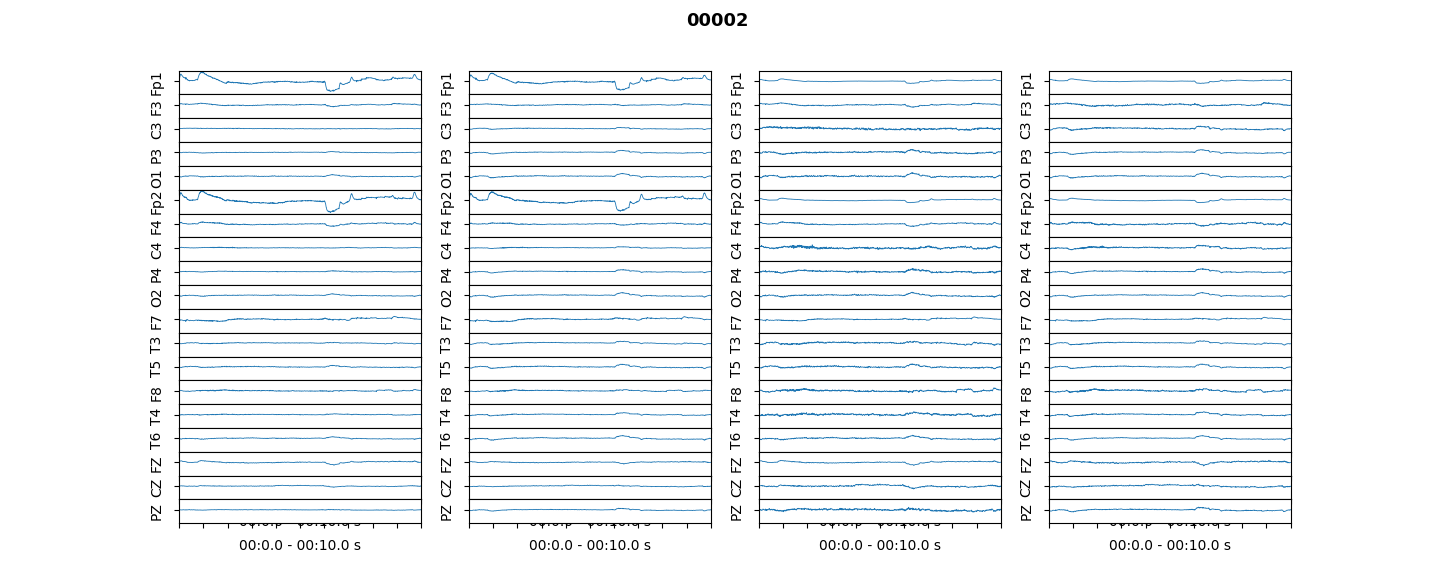

In [21]:
from matplotlib.gridspec import GridSpec
import scienceplots
import mpl_interactions
import mpl_interactions.ipyplot as iplt
from mpl_interactions import interactive_axvline
from mpl_interactions.controller import Controls
from functools import partial

%matplotlib ipympl
duration = 2000
sample_rate = 200
num = 1

def f1(signal, start, duration):
    return signal[start: start + duration]

def f2(signal, start, channel, duration):
    x = signal[:, start: start + duration].copy()
    x -= x.mean(axis=0, keepdims=True)
    return x[channel]

def f3(signal, start, duration):
    x = signal[start: start + duration].copy()
    x -= x.mean()
    x /= (x.std() + 1e-8)
    return x * 20

def f4(start, duration):
    t = start
    start_time = f"{int((t / sample_rate) // 60):02d}:{(t / sample_rate) % 60:02.1f}"
    t = start + duration
    end_time = f"{int((t / sample_rate) // 60):02d}:{(t / sample_rate) % 60:02.1f}"
    return start_time + " - " + end_time + " s"

def f5(signal, start, channel, duration):
    x = signal[:, start: start + duration].copy()
    x -= x.mean(axis=0, keepdims=True)
    x = x[channel]
    x -= x.mean()
    x /= (x.std() + 1e-8)
    return x * 20

with plt.style.context(['ieee', 'science', 'default']):  # science, ieee, default, fivethirtyeight
    # plt.rcParams.update({'font.family': 'Roboto Slab'})

    serial = annotation["data"][num]['serial']
    fname = os.path.join(curate_folder, 'signal/memmap', serial + '.dat')
    signal = np.array(np.memmap(fname, dtype='int32', mode='r').reshape(21, -1)).astype('float')
    C = 19
    signal = signal[:C]
    L = signal.shape[1]

    fig = plt.figure(num=1, clear=True, figsize=(30, 30))
    fig.subplots_adjust(hspace=0)
    fig.tight_layout()
    gs = GridSpec(nrows=C, ncols=4)
    ctrls = Controls(start=np.arange(0, L - duration))
    display(ctrls)

    for c in range(C):
        if c == 0:
            ax = fig.add_subplot(gs[c, 0])
            ax0 = ax
        else:
            ax = fig.add_subplot(gs[c, 0], sharey=ax0)

        iplt.plot(partial(f1, signal=signal[c], duration=duration), 
                  ax=ax, controls=ctrls["start"], lw=0.6)

        ax.set_xlim(0, duration)
        ax.set_ylabel(annotation['signal_header'][c].split('-')[0])
        mpl_interactions.interactive_xlabel(xlabel=partial(f4, duration=duration),
                                            controls=ctrls["start"])
        ax.set_xticks(np.arange(round(duration / sample_rate) + 1) * sample_rate)
        ax.set_xticklabels([])
        # ax.tick_params(axis='x', width=0.1, length=0.1)
        ax.set_yticks([0])
        ax.set_yticklabels([])

    for c in range(C):
        ax = fig.add_subplot(gs[c, 1], sharey=ax0)
        iplt.plot(partial(f2, signal=signal, channel=c, duration=duration), 
                  ax=ax, controls=ctrls["start"], lw=0.6)

        ax.set_xlim(0, duration)
        ax.set_ylabel(annotation['signal_header'][c].split('-')[0])
        mpl_interactions.interactive_xlabel(xlabel=partial(f4, duration=duration),
                                            controls=ctrls["start"])
        ax.set_xticks(np.arange(round(duration / sample_rate) + 1) * sample_rate)
        ax.set_xticklabels([])
        # ax.tick_params(axis='x', width=0.1, length=0.1)
        ax.set_yticks([0])
        ax.set_yticklabels([])

    for c in range(C):
        ax = fig.add_subplot(gs[c, 2], sharey=ax0)
        iplt.plot(partial(f3, signal=signal[c], duration=duration), 
                  ax=ax, controls=ctrls["start"], lw=0.6)

        ax.set_xlim(0, duration)
        ax.set_ylabel(annotation['signal_header'][c].split('-')[0])
        mpl_interactions.interactive_xlabel(xlabel=partial(f4, duration=duration),
                                            controls=ctrls["start"])
        ax.set_xticks(np.arange(round(duration / sample_rate) + 1) * sample_rate)
        ax.set_xticklabels([])
        # ax.tick_params(axis='x', width=0.1, length=0.1)
        ax.set_yticks([0])
        ax.set_yticklabels([])

    for c in range(C):
        ax = fig.add_subplot(gs[c, 3], sharey=ax0)
        iplt.plot(partial(f5, signal=signal, channel=c, duration=duration), 
                  ax=ax, controls=ctrls["start"], lw=0.6)

        ax.set_xlim(0, duration)
        ax.set_ylabel(annotation['signal_header'][c].split('-')[0])
        mpl_interactions.interactive_xlabel(xlabel=partial(f4, duration=duration),
                                            controls=ctrls["start"])
        ax.set_xticks(np.arange(round(duration / sample_rate) + 1) * sample_rate)
        ax.set_xticklabels([])
        # ax.tick_params(axis='x', width=0.1, length=0.1)
        ax.set_yticks([0])
        ax.set_yticklabels([])
    
    fig.suptitle(serial, fontsize=13, fontweight='semibold')

    plt.show()